In [60]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import *
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
import stimcirq
from typing import *
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import time
from tqdm import tqdm
import scipy.stats as ss
import pickle
from pymatching import Matching
from ldpc import bposd_decoder
import qsurface.decoders.unionfind as uf
from CompassCode import Lattice2D, choose_gauge_fixing, random_pauli, pcheck_clipX, pcheck_clipZ

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'matplotlib.blocking_input'

## Motivate 2D Compass Code Performance

### 2D Compass Codes vs Surface Code (Uniform Pauli Noise)

#### Minimum-Weight Perfect Matching

In [13]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.01, 10)
num_errors = 500 
bootstrapped_runs = 20
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [22:24<00:00, 224.13s/it]


In [14]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_surface_code_mwpm_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

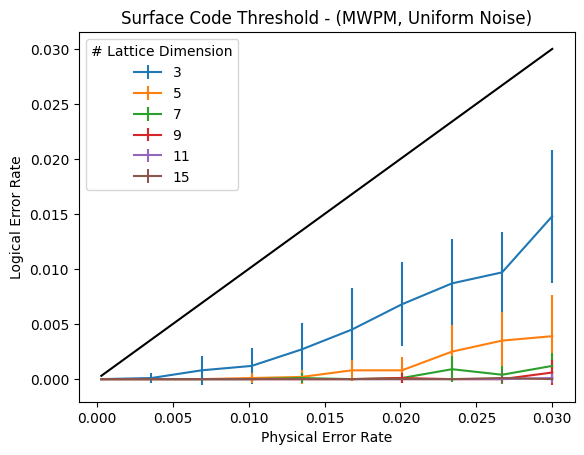

In [17]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (MWPM, Uniform Noise)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [24]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.1, 10)
num_errors = 100 
bootstrapped_runs = 10
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

100%|██████████| 6/6 [02:35<00:00, 25.88s/it]


In [25]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_lonf_surface_code_mwpm_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

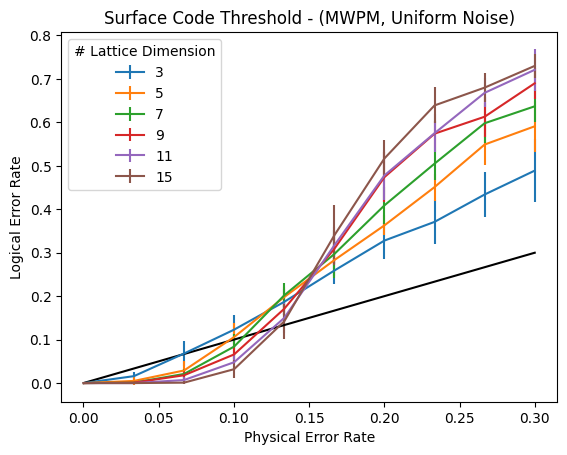

In [26]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (MWPM, Uniform Noise)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [16]:
# Compass Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.01, 10)
num_errors = 500 
num_gauge_fixings = 20
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1

100%|██████████| 6/6 [15:48<00:00, 158.13s/it]


In [19]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_compass_code_mwpm_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

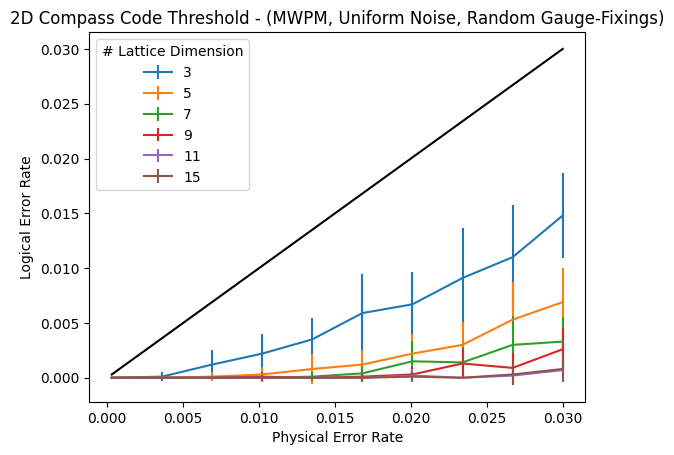

In [20]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('2D Compass Code Threshold - (MWPM, Uniform Noise, Random Gauge-Fixings)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [27]:
# Compass Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.1, 10)
num_errors = 100 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1

100%|██████████| 6/6 [01:59<00:00, 19.84s/it]


In [28]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_compass_code_mwpm_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

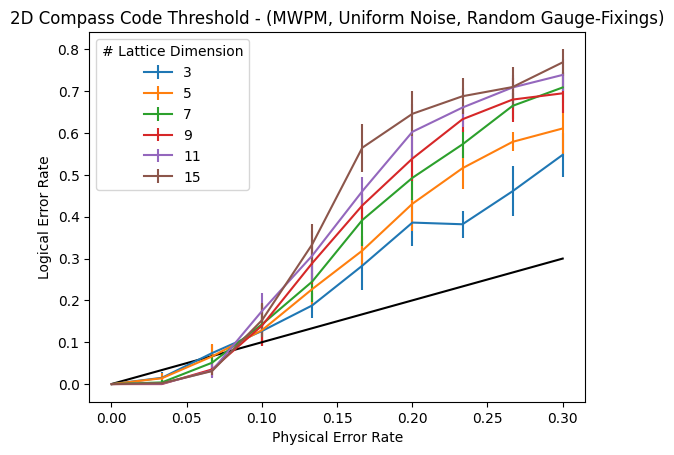

In [29]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('2D Compass Code Threshold - (MWPM, Uniform Noise, Random Gauge-Fixings)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

#### Belief Propagation + Ordered Statistics Decoding

In [21]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.01, 10)
num_errors = 500 
bootstrapped_runs = 20
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        num_qubits = lat.size()
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            error_probability = np.sum(rates)
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

100%|██████████| 6/6 [25:29<00:00, 254.89s/it]


In [22]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_surface_code_bposd_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

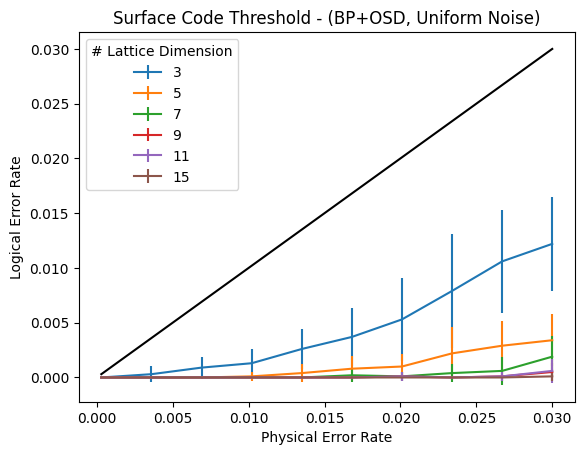

In [23]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (BP+OSD, Uniform Noise)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [46]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.1, 10)
num_errors = 100 
bootstrapped_runs = 10
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        num_qubits = lat.size()
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            error_probability = np.sum(rates)
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [03:03<00:00, 30.60s/it]


In [47]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_surface_code_bposd_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

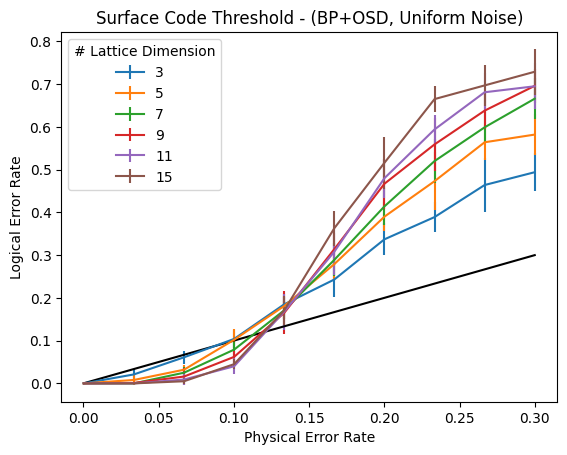

In [48]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (BP+OSD, Uniform Noise)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [50]:
# Compass Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.01, 10)
num_errors = 500 
num_gauge_fixings = 20
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 3 # Different from above!
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 3 # Different from above!
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [20:18<00:00, 203.03s/it]


In [51]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_compass_code_bposd_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

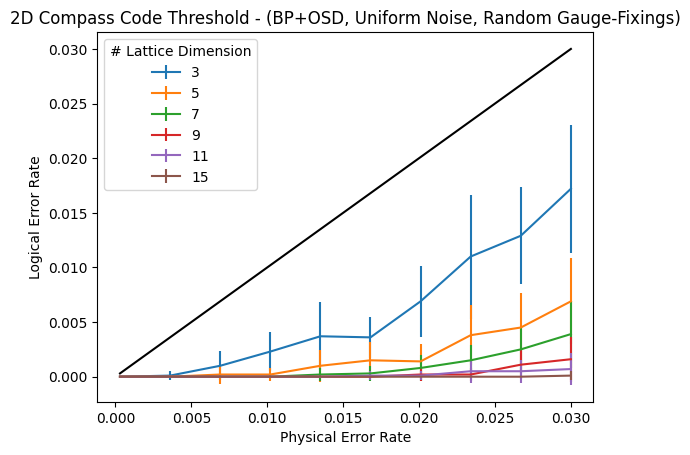

In [52]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('2D Compass Code Threshold - (BP+OSD, Uniform Noise, Random Gauge-Fixings)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [53]:
# Compass Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.1, 10)
num_errors = 100 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 3 # Different from above!
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 3 # Different from above!
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1

100%|██████████| 6/6 [02:24<00:00, 24.10s/it]


In [54]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_compass_code_bposd_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

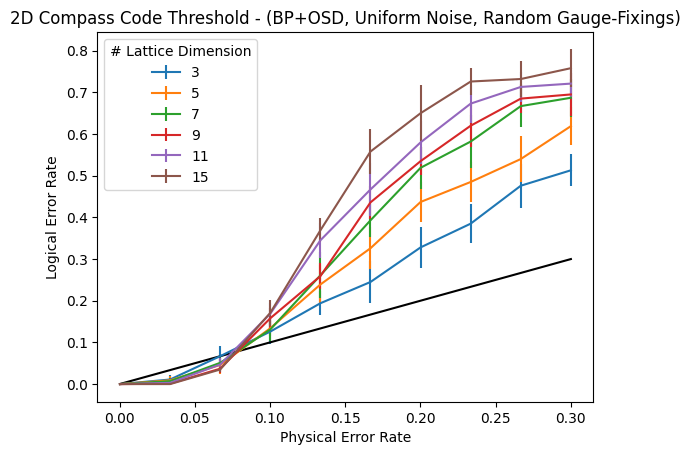

In [55]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('2D Compass Code Threshold - (BP+OSD, Uniform Noise, Random Gauge-Fixings)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

#### Union-Find